In [1]:
from nltk.stem import WordNetLemmatizer
import nltk

from summarizers import get_book_descriptions
from summarizers import frequent_ngrams
from summarizers import frequent_arbitrarygrams
from summarizers import sentimental_words
from batch_processor import get_reviews_text
from main import print_descriptions

2022-05-06 00:49:21.674769: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-06 00:49:21.674798: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
FILTER_SPOILERS = True
ASPECTS = ["book", "story", "writing", "characters", "pacing"]
SENT_THRESHOLD = 0.6
ENT_COUNT = 20

In [3]:
book_id = "3"
# harry potter and the sorcerer's stone = 3
# twilight = 41865
# the expanse = 8855321
# eric = 64218
# guards guards = 64216
# eidolon = 25056040

In [4]:
text, title, series = get_reviews_text(book_id, FILTER_SPOILERS, "fantasy_paranormal")

In [5]:
tokenized = nltk.word_tokenize(text)

In [6]:
lemmatizer = WordNetLemmatizer()
lemmatized = [
    lemmatizer.lemmatize(word, pos.lower()[0] if pos.lower()[0] in "nvars" else "n").lower()
    for word, pos in nltk.pos_tag(tokenized)
]

In [7]:
frequent_ngrams(lemmatized, 2)

FreqDist({('harry', 'potter'): 3400, ('first', 'time'): 620, ('first', 'book'): 582, ('potter', 'series'): 416, ('potter', 'book'): 410, ('read', 'harry'): 277, ('year', 'old'): 242, ('year', 'ago'): 212, ('even', 'though'): 207, ('whole', 'series'): 203, ...})

In [8]:
frequent_ngrams(lemmatized, 3)

FreqDist({('harry', 'potter', 'series'): 405, ('harry', 'potter', 'book'): 379, ('read', 'harry', 'potter'): 271, ('love', 'harry', 'potter'): 119, ('first', 'harry', 'potter'): 77, ('first', 'time', 'read'): 65, ('never', 'get', 'old'): 49, ('harry', 'potter', 'fan'): 46, ('like', 'harry', 'potter'): 37, ('11', 'year', 'old'): 37, ...})

In [9]:
frequent_arbitrarygrams(lemmatized, 2, 6, 3)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.74it/s]


[(('harry', 'potter', 'and', 'the', 'sorcerer', 'stone'), 208),
 (('read', 'the', 'rest', 'of', 'the', 'series'), 82),
 (('to', 'read', 'the', 'rest', 'of', 'the'), 74),
 (('the', 'first', 'time', 'i', 'read'), 116),
 (('ca', 'wait', 'to', 'read', 'the'), 79),
 (('first', 'time', 'i', 'read', 'it'), 74),
 (('first', 'harry', 'potter', 'book'), 55),
 (('time', 'read', 'harry', 'potter'), 19),
 (('first', 'read', 'harry', 'potter'), 18),
 (('harry', 'potter', 'series'), 413),
 (('love', 'harry', 'potter'), 124),
 (('never', 'get', 'old'), 49),
 (('year', 'old'), 242),
 (('year', 'ago'), 212),
 (('even', 'though'), 207)]

In [10]:
sentimental_words(lemmatized, 20, 0.5)

[('love', 3147, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}),
 ('great', 1121, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}),
 ('amazing', 637, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5859}),
 ('fun', 599, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5106}),
 ('best', 543, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}),
 ('wonderful', 389, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}),
 ('awesome', 261, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}),
 ('fantastic', 250, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}),
 ('loved', 236, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5994}),
 ('perfect', 232, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}),
 ('amaze', 230, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5423}),
 ('bad', 211, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423}),
 ('evil', 206, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.6597}),
 ('kind', 203,

In [11]:
print("chars", len(text))
print("words", len(text.split()))

chars 2763344
words 510745


In [12]:
result = get_book_descriptions(book_id, text, ENT_COUNT, ASPECTS, SENT_THRESHOLD, title, series)
names_mapping, character_descriptions, aspect_descriptions, sentimental_descriptions, doc = result

In [13]:
names_mapping

{'Harry Potter': 'Harry Potter',
 'Harry': 'Harry',
 'Rowling': 'Rowling',
 'Hogwarts': 'Hogwarts',
 'Ron': 'Ron',
 'J.K. Rowling': 'Rowling',
 'Dumbledore': 'Dumbledore',
 'Hermione': 'Hermione',
 'Voldemort': 'Voldemort',
 'Dursleys': 'Dursleys',
 'Jim Dale': 'Jim Dale',
 'Quidditch': 'Quidditch',
 'Neville': 'Neville',
 'J. K. Rowling': 'Rowling',
 "J.K. Rowling's": 'Rowling',
 'J.K Rowling': 'Rowling',
 'harry potter': 'Harry Potter',
 "Harry Potter's": 'Harry Potter',
 'Hermione Granger': 'Hermione',
 'Ron Weasley': 'Ron'}

Harry Potter 402


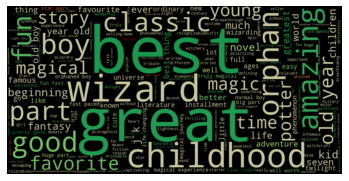

first book in 7 book harry potter series by author j.k rowling
fantastic beginning to one of greatest book series of time
first book in well known series all about wizarding world
first book in rowling 's phenomenal harry potter series
great beginning to wonderful series by j. k. rowling
sweetest most delightful peice of candied literature
first step towards magical world full of adventures
most successful book series popular with children

Rowling 190


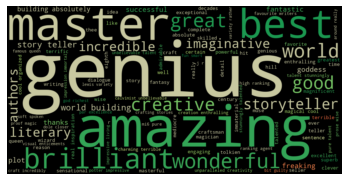

sensational author with her wonderful detail in her world building
really talented writer with unparalleled creativity
just as successful at world building as j.r.r.
closer to lewis ' variety rather than tolkien
one of thee best authors in freaking world
unbelievable talent for first impression
one of world 's most incredible authors

Harry 182


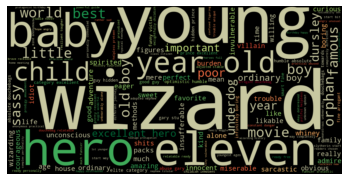

just pitiful helpless preteen with packs of troubles
one of most famous figures in wizarding history
lot younger than one in methods of rationality
bit more whiney in books than in movies
more important than burden of nephew
absolute douchebags towards hermione
never prejudiced against slytherin

Ron 80


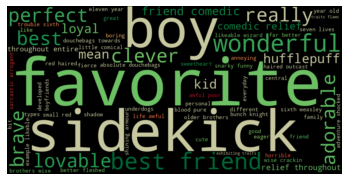

comedic relief throughout entire series for me
absolute douchebags towards hermione
my favorite character with hermione
one of my first book boyfriends
in shadow of his older brothers
my favorite underdogs of bunch

Hermione 50


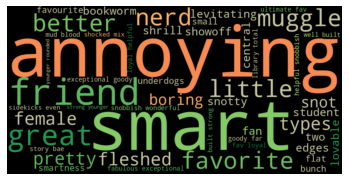

my favorite underdogs of bunch
far better fleshed than harry
wonderful friends to harry
great female character
my favourite character

Dumbledore 46


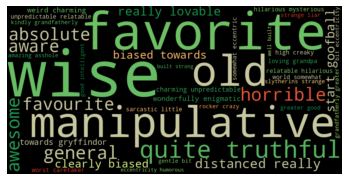

clearly biased towards gryffindor in general
not one of my favourite characters of series
one of my most favorite characters
charming unpredictable relatable
off his rocker crazy old man-

Hogwarts 39


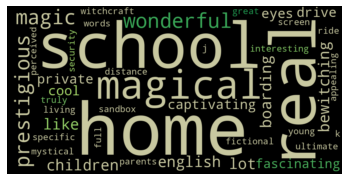

lot like english boarding school
distance from one 's parents
ultimate sandbox for author
place of perceived security
very fascinating place

Voldemort 29


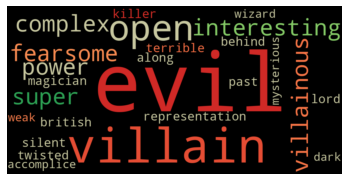

representation of evil 's of british past
one behind it along with his accomplice
not very interesting villain
super complex characters

Jim Dale 29


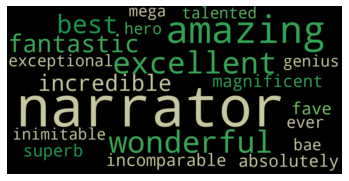

absolutely fantastic narrator
genius narrator for series
one of my fave narrators
mega talented narrator

Dursleys 19


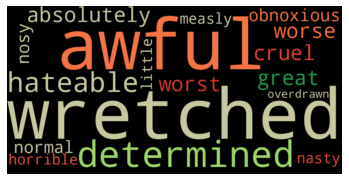

absolutely great characters
little overdrawn
very hateable
determined

Neville 16


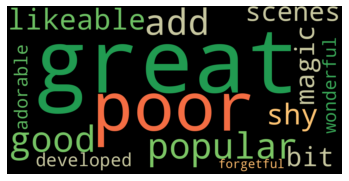

bit more developed
popular character
so likeable
wonderful

book 2898


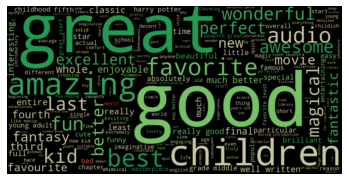

beginning to awesome harry potter series by j.k. rowling
so much more magical in its original language
my least favorite book in harry potter series
surprisingly reflective of childhood psyche
about his first year in wizarding school
great set up for entire potter universe
one of greatest displays of imagination
great example of amazing fantasy book
collection of elements from mythology
more unique than set of fingerprints
lot like movie unlike some of others

story 601


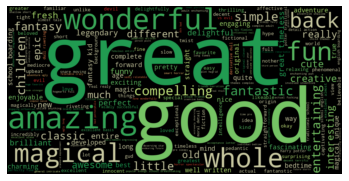

about origins of things of intelligence
not my acceptance letter to hogwarts
so plain spoken so straightforward
engaging with great twist at end
excellent basis to magical world
from third person point of view
more about younger generation
so compelling good vs. evil
extremely deserving of hype

characters 560


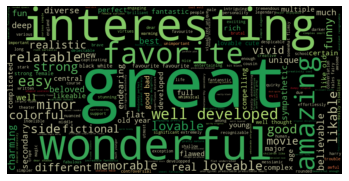

so much more sympathetic in her books than in movies
unique with exception of harry 's cousin
well developed for just one book
very different from one to other
shadow of characters in books
as complicated as real people
wonderful with their virtues
pretty mature for their age
so strong especially draco

writing 178


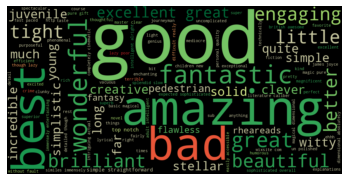

http://rheareads.wixsite.com/rheareads
far more juvenile than rest of novel
simple explanations too long
more journeyman than master
easily accessible for adult
far superior to most things
little light for my taste

pacing 14


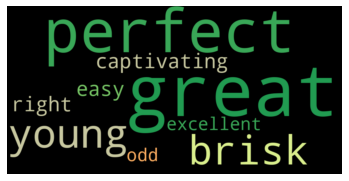

perfect for young reader
captivating
excellent



In [14]:
extra_stopwords = {
    "character", "characters", "writer", "author", "one", "first", "second", "last"
    "whole", "book", "books", "series", "man", "woman", "place", "next",
    "able", "read", "reader", "main", "many", "previous", "1st", "2nd", "3rd", "4th", "6th", "7th"
}

print_descriptions(character_descriptions, min_descs=10, extra_stopwords=extra_stopwords)
print_descriptions(aspect_descriptions, min_descs=10, extra_stopwords=extra_stopwords)

great 935


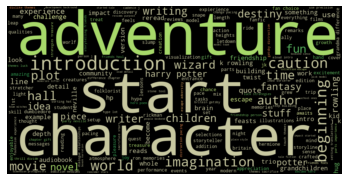

introduction of worlf of harry potter
j.k. rowlings imagination
poem from sorting hat
idea of wizard school
harry potter series
lot of modern books
rowling 's fantasy
audiobook version
first potter book

best 468


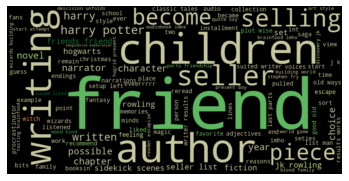

first book from saga of harry potter from my point of view
audio books in harry potter series
jk rowling 's first harry potter
harry 's first year at hogwarts
imaginative exploration
writing of first book
plot wise rowling
tasting brainfood

love 275


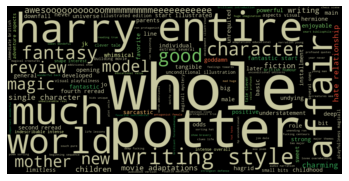

understatement about my feelings towards series
awesooooooooooommmmmmmmmeeeeeeeeeee
never not brilliant introduction
strongest defense against evil
most powerful magic on earth
brilliant foreshadowing
character development
not smart bibliophile

awesome 139


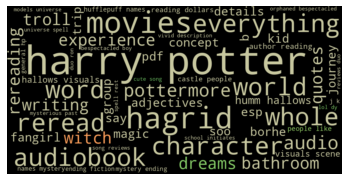

vivid description of orphaned bespectacled boy with very mysterious past
scene with troll in bathroom
whole harry potter series
whole concept in general
audio book on pottermore
only word for book
harry potter books

evil 100


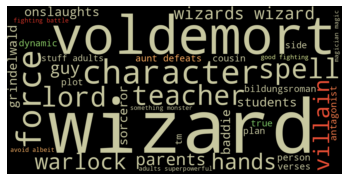

wizard grindelwald
wizard voldemort
bildungsroman
superpowerful
avoid albeit
antagonist)-

perfectly 69


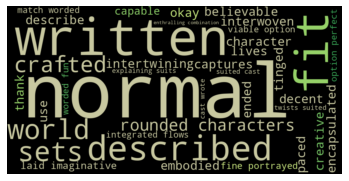

enthralling combination
rounded characters
encapsulated world
imaginative world
decent character
creative story

greatest 57


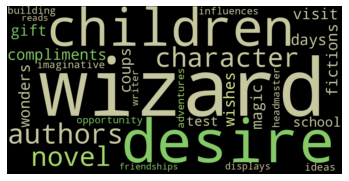

imaginative ideas
compliments
opportunity
friendships
not writer

worst 24


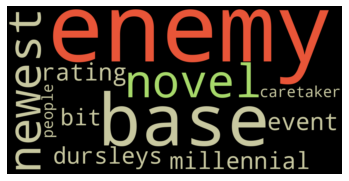

newest rating
first novel
millennial
caretaker

brilliantly 21


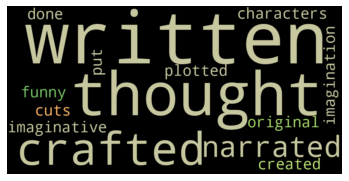

imaginative thought funny
written imagination
written 
 
characters

lovable 19


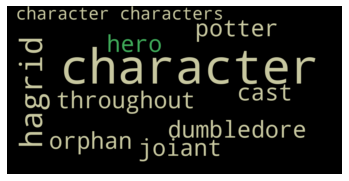

characters throughout series
are characters
characters
dumbledore

dead 17


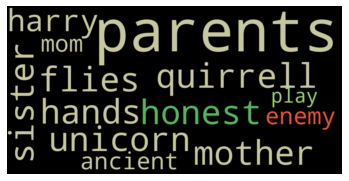

harry 's ancient enemy
his parents
her sister
my parents

superb 14


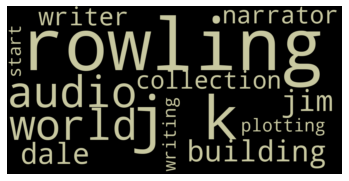

rowling 's writing
world building
j.k. rowling

masterpiece 14


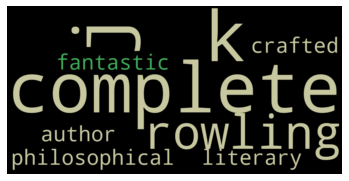

author 's first book
j. k. rowling 's
philosophical

outstanding 14


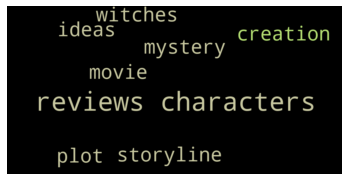

characters
storyline
creation

abusive 12


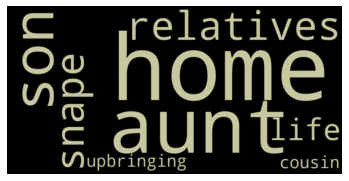

upbringing
relatives
cousin

hatred 11


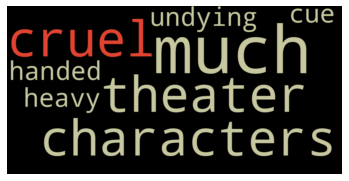

characters
theater
undying

abuse 11


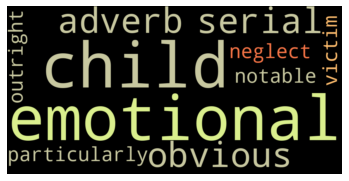

particularly notable
emotional
outright

villains 11


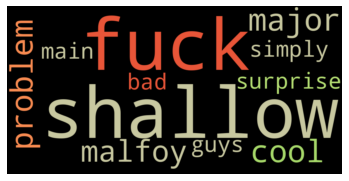

other major problem
simply bad guys
shallow as fuck



In [15]:
forbidden_sentimentals = {
    "thing", "things", "one", "way", "part", "deal", "job", "first",
    "book", "books", "serie", "series", "story", "stories", "read",
    "literature", "sequel"
}
print_descriptions(sentimental_descriptions, min_descs=10, extra_stopwords=forbidden_sentimentals)

In [17]:
character_desc_count = sum(len(word_descs[1]) for word_descs in character_descriptions.items())
aspect_desc_count = sum(len(word_descs[1]) for word_descs in aspect_descriptions.items())
sentimental_desc_count = sum(len(word_descs[1]) for word_descs in sentimental_descriptions.items())

print("characters", character_desc_count)
print("aspects", aspect_desc_count)
print("sentimental", sentimental_desc_count)
print("total", len(list(doc.sents)))
print()

sum_ = character_desc_count + aspect_desc_count + sentimental_desc_count
total = len(list(doc.sents))

print("percentage", f"{sum_ / total * 100:.2f} %")

count = 0
unique_descs = 0
word_descs = 0
for descss in [character_descriptions, aspect_descriptions, sentimental_descriptions]:
    for key, descs in descss.items():
        count += len(descs)
        unique_descs += len(set(" ".join(w.text for w in desc) for desc in descs))
        word_descs += sum(len(desc) for desc in descs)

print("count", count)
print("unique_descs", unique_descs)
print("word_descs", word_descs)

print(len(doc))

characters 1089
aspects 4251
sentimental 2304
total 35534

percentage 21.51 %
count 7644
unique_descs 3361
word_descs 10740
602343
